In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

In [0]:
G=9.8
M=1
sin=np.sin
cos=np.cos
atan2=math.atan2
pi=np.pi
I=10.
T=0.1
STEPS=10000

In [0]:
def Rot(x,y,z):
    cx=cos(x)
    cy=cos(y)
    cz=cos(z)
    sx=sin(x)
    sy=sin(y)
    sz=sin(z)
    rot_m=np.array([[cz*cy, cz*sy*sx - sz*cx, cz*sy*cx + sz*sx], [sz*cy, sz*sy*sx + cz*cx, sz*sy*cx - sx*cz], [-sy, cy*sx, cy*cx]])
    return rot_m

In [4]:
Rot(0,0,pi/2)

array([[ 6.123234e-17, -1.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  6.123234e-17,  0.000000e+00],
       [-0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [0]:
def dyn_model(state, inp):
    #x y z xd yd zy angx angy angz angxd angyd angzd
    state=np.asarray(state, dtype="float64")
    inp=np.asarray(inp, dtype="float64")
    assert len(state)==12
    assert len(inp)==4
    new_state=state
    #start with adding the velocity and gravity
    new_state[:6]+=np.array([state[3],state[4],state[5],0,0,-G])*T #lin pos and vel
    new_state[6:9]+=np.array([state[9], state[10], state[11]])*T  #ang pos and vel
    thrust=Rot(state[6],state[7],state[8])@np.array([0,0,inp[0]])  #calculate the rotated thrust
    #add input contribution
    new_state[3]+=(1/M)*thrust[0]*T #adding linear input to velocities
    new_state[4]+=(1/M)*thrust[1]*T
    new_state[5]+=(1/M)*thrust[2]*T
    new_state[9]+=(1/I)*inp[1]
    new_state[10]+=(1/I)*inp[2]
    new_state[11]+=(1/I)*inp[3]
    return new_state

In [6]:
state=[0,0,0,0,0,0,0,0,0,0,0,0]
inp=[9.8,0.1,0,0]
state=dyn_model(state,inp)
print(state)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.  ]


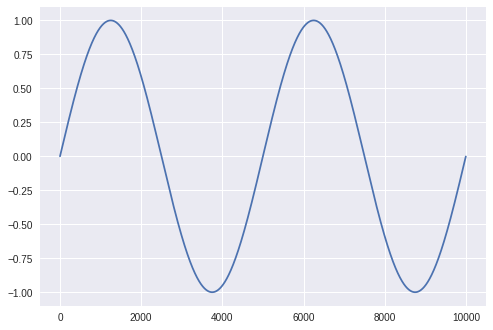

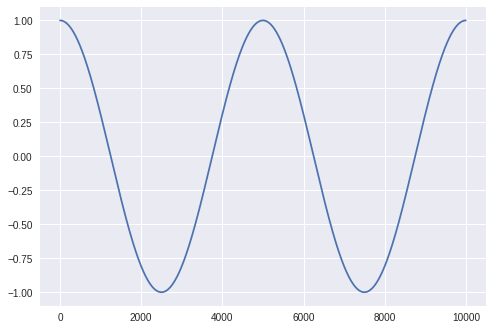

In [7]:
d_y=[]
for i in range(STEPS):
    d_y.append(sin(2*np.pi*2*i/STEPS))
plt.plot(d_y)
plt.show()

d_yd=[]
for i in range(STEPS):
    d_yd.append(cos(2*np.pi*2*i/STEPS))
plt.plot(d_yd)
plt.show()

# 1D Traj Following

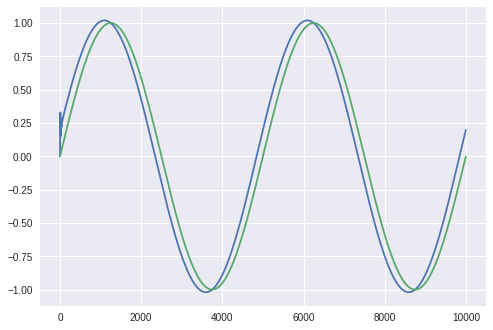

In [8]:
state=np.zeros(12, dtype="float64")
history=[]
for t in range(STEPS):
    
    inp=np.array([0.,0.,0.,0.])
    inp[0]+=9.8
    inp[0]+=10*(d_y[t]-state[2])+2*(d_yd[t]-state[5])
  #  print("desired state {} actual state {} input: {}".format(d_y[t],state[2],inp[0]-9.8))
    state=dyn_model(state,inp)
    history.append(state[2])
history=np.asarray(history)
plt.plot(history)
plt.plot(d_y)
plt.show()

# 2D Regulation

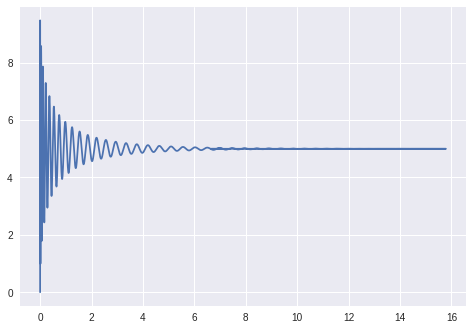

In [9]:
state=[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
history_x=[]
history_y=[]
d_z=5
d_zd=0.
d_y=10.
d_yd=0.
goals=[]
time=[]
for t in range(STEPS):
    time.append(t)
    inp=np.array([0.,0.,0.,0.])
    d_phi=(0.05*(d_yd-state[3]) + 0.001*(d_y-state[0]))/G  #PD x che trova angolo
 
  #  print("d phi",d_phi)
   
    inp[2]=0.01*(d_phi-state[7]) + 0.05*(-state[10]) + 0.2*(-state[7])  #PD ANGOLO
 #   print("angular input",inp[2])
 #   print("angle", state[7])
    
    inp[0]=(G + 0.1*(-state[5]) + 0.5*(d_z - state[2])) #PD z, 0.5 and 0.5 gives great performance on both axis
    state=dyn_model(state,inp)
 #   print("state",state[:3])
    history_x.append(state[0])
    history_y.append(state[2])
    """if t is not 0 and t % 5000 == 0:
        goals.append((d_x,d_y))
        plt.scatter(d_x,d_y, color="red")
     #   d_x += np.random.rand()*10 - 5
     #   d_y += np.random.rand()*10 - 5
        d_x= 10*cos(2*np.pi*t/200000)
        d_y= 10*sin(2*np.pi*t/200000)
    """
#plt.plot(history_x)
#plt.plot(history_y)
#plt.plot(d_x, d_y)
#plt.show()
plt.plot(history_x,history_y)
plt.show()

# 2D Trajectory tracking with sequential regulation. 1 lap.

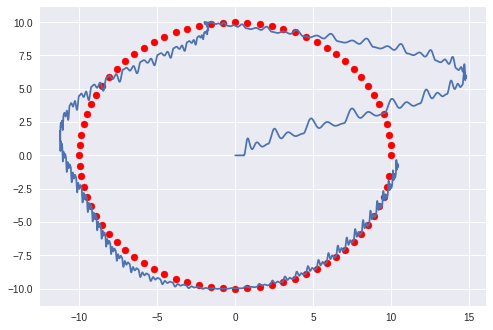

In [10]:
state=[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
history_x=[]
history_y=[]
d_z=0
d_zd=0.
d_y=10.
d_yd=0.
goals=[]
LAPS=1
for t in range(4*STEPS):
    time.append(t)
    inp=np.array([0.,0.,0.,0.])
    d_phi=(0.05*(d_yd-state[3]) + 0.001*(d_y-state[0]))/G  #PD x che trova angolo
 
  #  print("d phi",d_phi)
   
    inp[2]=0.01*(d_phi-state[7]) + 0.05*(-state[10]) + 0.2*(-state[7])  #PD ANGOLO
 #   print("angular input",inp[2])
 #   print("angle", state[7])
    
    inp[0]=(G + 0.1*(-state[5]) + 0.1*(d_z - state[2])) #PD z, 0.5 and 0.5 gives great performance on both axis
    state=dyn_model(state,inp)
 #   print("state",state[:3])
    history_x.append(state[0])
    history_y.append(state[2])
    if t is not 0 and t % 500 == 0:
        goals.append((d_y,d_z))
        plt.scatter(d_y,d_z, color="red")
     #   d_x += np.random.rand()*10 - 5
     #   d_y += np.random.rand()*10 - 5
        d_y= 10*cos(2*np.pi*t/(2*LAPS*20000))
        d_z= 10*sin(2*np.pi*t/(2*LAPS*20000))
    
#plt.plot(history_x)
#plt.plot(history_y)
#plt.plot(d_x, d_y)
#plt.show()
plt.plot(history_x,history_y)
plt.show()

# 3D regulation.

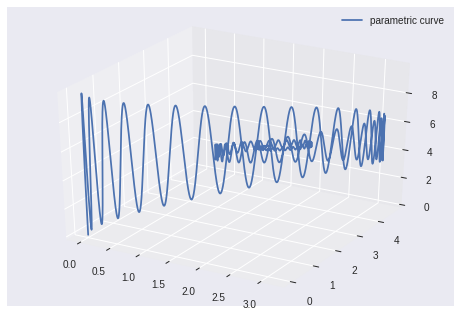

In [11]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

state=[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
history_x=[]
history_y=[]
history_z=[]
d_z=5
d_zd=0.
d_x=2.
d_xd=0.
d_y=3.
d_yd=0.
goals=[]
time=[]
for t in range(2*STEPS):
    time.append(t)
    inp=np.array([0.,0.,0.,0.])
    d_phi=(0.05*(d_xd-state[3]) + 0.001*(d_x-state[0]))/G  #PD x che trova angolo
    d_theta=(0.05*(d_yd-state[4]) + 0.001*(d_y-state[1]))/G
  #  print("d phi",d_phi)
   
    inp[2]=0.01*(d_phi-state[7]) + 0.05*(-state[10]) + 0.2*(-state[7])  #PD ANGOLO y per muovere x
    inp[1]=-0.01*(d_theta-state[6]) + 0.05*(-state[9]) + 0.2*(-state[6])  #PD ANGOLO x per muovere y. Cambio segno: angolo x positivo muove y neg
 #   print("angular input",inp[2])
 #   print("angle", state[7])
    
    inp[0]=(G + 0.01*(-state[5]) + 0.05*(d_z - state[2])) #PD z, 0.5 and 0.5 gives great performance on both axis
    state=dyn_model(state,inp)
 #   print("state",state[:3])
    history_x.append(state[0])
    history_y.append(state[1])
    history_z.append(state[2])
    """if t is not 0 and t % 5000 == 0:
        goals.append((d_x,d_y))
        plt.scatter(d_x,d_y, color="red")
     #   d_x += np.random.rand()*10 - 5
     #   d_y += np.random.rand()*10 - 5
        d_x= 10*cos(2*np.pi*t/200000)
        d_y= 10*sin(2*np.pi*t/200000)
    """
#plt.plot(history_x)
#plt.plot(history_y)
#plt.plot(d_x, d_y)
#plt.show()
"""
plt.plot(history_x,history_y)
plt.show()
plt.plot(history_x,history_z)
plt.show()
plt.plot(history_y,history_z)
plt.show()"""
ax.plot(history_x, history_y, history_z, label='parametric curve')
ax.legend()
plt.show()

# 3D traj track as regulation.

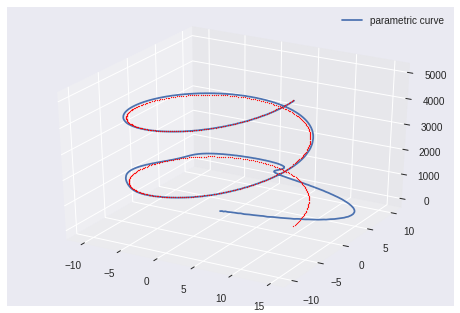

In [12]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

state=[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
history_x=[]
history_y=[]
history_z=[]
d_z=0
d_zd=0.
d_x=10.
d_xd=0.
d_y=0.
d_yd=0.
goals=[]
time=[]
for t in range(10*STEPS):
    time.append(t)
    inp=np.array([0.,0.,0.,0.])
    d_phi=(0.05*(d_xd-state[3]) + 0.001*(d_x-state[0]))/G  #PD x che trova angolo
    d_theta=(0.05*(d_yd-state[4]) + 0.001*(d_y-state[1]))/G
  #  print("d phi",d_phi)
   
    inp[2]=0.01*(d_phi-state[7]) + 0.05*(-state[10]) + 0.2*(-state[7])  #PD ANGOLO y per muovere x
    inp[1]=-0.01*(d_theta-state[6]) + 0.05*(-state[9]) + 0.2*(-state[6])  #PD ANGOLO x per muovere y. Cambio segno: angolo x positivo muove y neg
 #   print("angular input",inp[2])
 #   print("angle", state[7])
    
    inp[0]=(G + 0.01*(-state[5]) + 0.05*(d_z - state[2])) #PD z, 0.5 and 0.5 gives great performance on both axis
    state=dyn_model(state,inp)
 #   print("state",state[:3])
    history_x.append(state[0])
    history_y.append(state[1])
    history_z.append(state[2])
    if t is not 0 and t % 200 == 0:
        goals.append((d_x,d_y))
        ax.scatter(d_x,d_y, d_z, s=1, color="red")
     #   d_x += np.random.rand()*10 - 5
     #   d_y += np.random.rand()*10 - 5
        d_x= 10*cos(2*np.pi*t/(5*STEPS))
        d_y= 10*sin(2*np.pi*t/(5*STEPS))
        d_z+=10
#plt.plot(history_x)
#plt.plot(history_y)
#plt.plot(d_x, d_y)
#plt.show()
"""
plt.plot(history_x,history_y)
plt.show()
plt.plot(history_x,history_z)
plt.show()
plt.plot(history_y,history_z)
plt.show()"""
ax.plot(history_x, history_y, history_z, label='parametric curve')
ax.legend()
plt.show()

# Evolutionary algorithms.

In [0]:
def gen_rand_w():
    w_1= (np.random.randn(20,6))*0
    w_2 = (np.random.randn(20,21))*0
  #  w_3 = (np.random.randn(10,11))
  #  w_4 = (np.random.randn(15,16))
  #  w_5 = (np.random.randn(15,16))
  #  w_6 = (np.random.randn(15,16))
    w_3 = (np.random.randn(3,21))*0
    w=[]
    w.append(w_1)
    w.append(w_2)
    w.append(w_3)
 #   w.append(w_4)
#    w.append(w_5)
#    w.append(w_6)
#    w.append(w_7)
    return w

In [0]:
def evolve_w(w, alpha):
    
    dir=copy.deepcopy(w)
    dir[0]= (np.random.randn(20,6))*alpha
    dir[1] = (np.random.randn(20,21))*alpha
   # dir[2] += (np.random.randn(10,11))*alpha
  #  w[3] += (np.random.randn(15,16))*alpha
  #  w[4] += (np.random.randn(15,16))*alpha
  #  w[5] += (np.random.randn(15,16))*alpha
    dir[2] = (np.random.randn(3,21))*alpha
    
    w[0]+= dir[0]
    w[1] += dir[1]
  #  w[2] += (np.random.randn(10,11))*alpha
  #  w[3] += (np.random.randn(15,16))*alpha
  #  w[4] += (np.random.randn(15,16))*alpha
  #  w[5] += (np.random.randn(15,16))*alpha
    w[2] += dir[2]
  #  w[3] += dir[3]
    
    dir_flat=[]
    dir_flat=dir_flat+list(dir[0].flatten())
    dir_flat=dir_flat+list(dir[1].flatten())
    dir_flat=dir_flat+list(dir[2].flatten())
  #  print(dir_flat)
    return dir

In [0]:
def feedf(x, w):
    x=np.asarray(x)
    x=np.append(x,1)
    y=np.dot(w[0],x)
    y=np.tanh(y)
    y=np.append(y,1)
    y2=np.dot(w[1],y)
    y2=np.tanh(y2)
    y2=np.append(y2,1)
  
    y3=np.dot(w[2],y2)
    return y3

# Training phase

In [0]:
def run(w, clip=1, gain=0.0000001, wind=0):
    import matplotlib as mpl
    from mpl_toolkits.mplot3d import Axes3D


    mpl.rcParams['legend.fontsize'] = 10

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    state=[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
    history_x=[]
    history_y=[]
    history_z=[]
    d_z=0
    d_zd=0.
    d_x=10.
    d_xd=0.
    d_y=0.
    d_yd=0.
    goals=[]
    time=[]
    loss=0
    for t in range(10*STEPS):
        time.append(t)
        inp=np.array([0.,0.,0.,0.])
        d_phi=(0.05*(d_xd-state[3]) + 0.001*(d_x-state[0]))/G  #PD x che trova angolo
        d_theta=(0.05*(d_yd-state[4]) + 0.001*(d_y-state[1]))/G
      #  print("d phi",d_phi)

        inp[2]=0.01*(d_phi-state[7]) + 0.05*(-state[10]) + 0.2*(-state[7])  #PD ANGOLO y per muovere x
        inp[1]=-0.01*(d_theta-state[6]) + 0.05*(-state[9]) + 0.2*(-state[6])  #PD ANGOLO x per muovere y. Cambio segno: angolo x positivo muove y neg
     #   print("angular input",inp[2])
     #   print("angle", state[7])

        inp[0]=(G + 0.01*(-state[5]) + 0.05*(d_z - state[2])) #PD z, 0.5 and 0.5 gives great performance on both axis
       
        inp[0]+=gain*feedf([d_x-state[0],d_y - state[1], d_z - state[2], d_phi-state[6], d_theta-state[7]], w)[0]
        inp[1]+=gain*feedf([d_x-state[0],d_y - state[1], d_z - state[2], d_phi-state[6], d_theta-state[7]], w)[1]
        inp[2]+=gain*feedf([d_x-state[0],d_y - state[1], d_z - state[2], d_phi-state[6], d_theta-state[7]], w)[2]
        
        loss+=(d_y - state[1])**2  + (d_x-state[0])**2 + (d_z - state[2])**2 + 0.0*((-state[5])**2 + (-state[4])**2 + (-state[3])**2) + 0.1*(inp[0]**2 + inp[1]**2 + inp[2]**2)
        state=dyn_model(state,inp)
     #   print("state",state[:3])
        history_x.append(state[0])
        history_y.append(state[1])
        history_z.append(state[2])
        if t is not 0 and t % 200 == 0:
            goals.append((d_x,d_y))
            ax.scatter(d_x,d_y, d_z, s=1, color="red")
         #   d_x += np.random.rand()*10 - 5
         #   d_y += np.random.rand()*10 - 5
            d_x= 10*cos(2*np.pi*t/(5*STEPS))
            d_y= 10*sin(2*np.pi*t/(5*STEPS))
            d_z+=10
        if wind:
          if t is not 0 and t % 50000 == 0:
            state+=np.array([0,0,0,0,1,1,0,0,0,0,0,0]) #add a velocity for wind
    #plt.plot(history_x)
    #plt.plot(history_y)
    #plt.plot(d_x, d_y)
    #plt.show()
    """
    plt.plot(history_x,history_y)
    plt.show()
    plt.plot(history_x,history_z)
    plt.show()
    plt.plot(history_y,history_z)
    plt.show()"""
    ax.plot(history_x, history_y, history_z, label='parametric curve')
    ax.legend()
    plt.show()
    return loss

In [0]:
def train(start_from_zero=1, w_input=0, gain=0.0000001, wind=0):
    if start_from_zero:
        w=gen_rand_w()

        w_try=gen_rand_w()
        w_best=gen_rand_w()
    else:
        w_best=w_input
    count=0

    new=True
    #    alpha=0.2
    for alpha in (0.7,0.4,0.2,0.05):
        for _ in range(0,20):
            count+=1
            print("new direction")
            w_try=copy.deepcopy(w_best)
            if new:
                loss1=run(w_try, clip=1, gain=gain, wind=wind)
            print("loss 1: " + str(loss1))


            dir=evolve_w(w_try,alpha)
            loss2=run(w_try, clip=1, gain=gain, wind=wind)

            print("loss 2: " + str(loss2))

            diff=loss2-loss1
            new=False
            while diff<-1:
                new=True
                loss_min=loss2
                count+=1
                w_best=copy.deepcopy(w_try)
                print("improve")
                loss1=loss2

                w_try[0]+=dir[0]*0.33#*diff*0.05
                w_try[1]+=dir[1]*0.33#*diff*0.05
                w_try[2]+=dir[2]*0.33#*diff*0.05

                loss2=run(w_try, clip=1, gain=gain, wind=wind)
                diff=loss2-loss1

                print("loss new: " + str(loss2))
    print("step totali: " + str(count))
    print("best loss: " + str(loss_min) )
    return w_best

In [ ]:
w_b2=train(start_from_zero=1, gain=0.0000003, wind=1)

In [ ]:
run(clip=1,w=gen_rand_w(), wind=1)